## 98.5% of accuacy with 50 labels

## Goal

In thie programming assignment, we use an example to show how we can use autoencoders and clustering to improve classification results.

We use the mnist data set for this purpose. We are only allowed to lable 50 images from the training data set. But we are free to choose which 50 images to label.

Given this limitation, we will combine autoencoders and clustering to reach a classification accuracy above 98.5%.

## Grading Policy

This programming assignment is graded based on the achieved test accuracy. Any accuracy above 98.5% is graded as 100, whereas any accuracy below 97.5% is graded as 0. Any accuracy in between will be graded using the formula

(test_acc - 0.975)*10000

## Load the data

First, we load the mnist data and normalize the images. Note we use the last 5000 samples in the x_train_full for validation.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

11490434/11490434 [==============================] - 3s 0us/step


In [2]:
print(x_train.shape, x_valid.shape, x_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


Next, we reshape the images to (28, 28, 1).

In [3]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_valid = np.reshape(x_valid, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

We print out the first 50 training images.

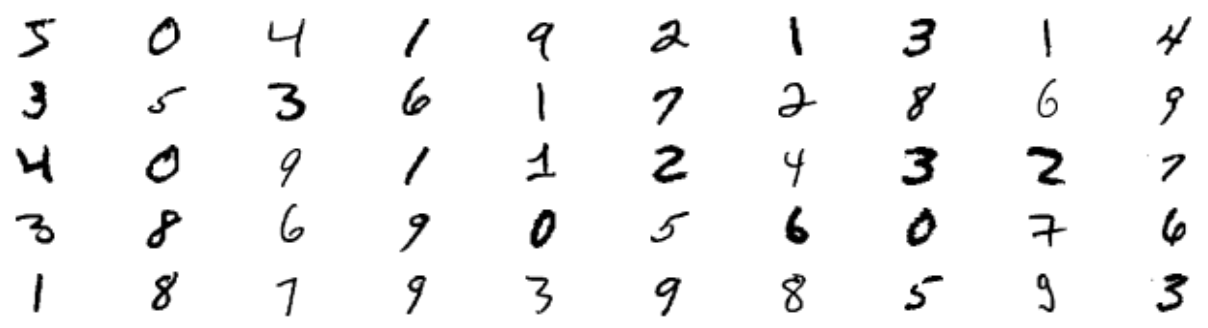

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
for index, digit in enumerate(x_train[:50]):
    plt.subplot(50 // 10, 10, index + 1)
    plt.imshow(digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

# Build  an autoencoder

First import some modules needed for this part of the code.

In [5]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

We build a autoencoder using Conv2D layers.

First, we build the encoder. Hint: study the code from this module. Try different latent_dim settings.

In [33]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [36]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
x = Dropout(0.5)(x)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
# inputs = Input(shape=(image_size, image_size, 1))
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Flatten()(x)
# latent_vector = Dense(latent_dim, name='latent_vector')(x)

In [37]:
# shape info needed to build decoder model
shape = K.int_shape(x)

In [38]:
# generate latent vector
# latent_inputs = Input(shape=(latent_dim,))
# x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# generate latent vector
# latent_vector = Dense(latent_dim, name='latent_vector')(x)


In [39]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (26

Now we build the decoder. Note in the decoder we use Conv2DTranspose layers.

In [40]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [41]:
# stack of Conv2DTranspose( )-Conv2DTranspose( )
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# x = Dense(np.prod(shape[1:]))(decoder_input)
# x = Reshape((shape[1], shape[2], shape[3]))(x)

# x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
# x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
# decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

In [42]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [43]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense_5 (Dense)             (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

Combine the encoder and the decoder as the autocoder.

In [44]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the autoencoder. 

In [45]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

Train the autoencoder. Use restore_best_weights to restore the best weights.

In [46]:
# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_valid, x_valid),
                epochs=100,
                batch_size=batch_size, callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/100
1719/1719 [==============================] - 59s 33ms/step - loss: 0.0258 - val_loss: 0.0364
Epoch 2/100
1719/1719 [==============================] - 54s 31ms/step - loss: 0.0133 - val_loss: 0.0337
Epoch 3/100
1719/1719 [==============================] - 49s 29ms/step - loss: 0.0121 - val_loss: 0.0314
Epoch 4/100
1719/1719 [==============================] - 51s 29ms/step - loss: 0.0114 - val_loss: 0.0378
Epoch 5/100
1719/1719 [==============================] - 53s 31ms/step - loss: 0.0109 - val_loss: 0.0351
Epoch 6/100
1719/1719 [==============================] - 55s 32ms/step - loss: 0.0106 - val_loss: 0.0345
Epoch 7/100
1719/1719 [==============================] - 56s 32ms/step - loss: 0.0103 - val_loss: 0.0348
Epoch 8/100
1719/1719 [==============================] - 54s 32ms/step - loss: 0.0101 - val_loss: 0.0309
Epoch 9/100
1719/1719 [==============================] - 54s 31ms/step - loss: 0.0099 - val_loss: 0.0309
Epoch 10/100
1719/1719 [==============================]

Plot training and validation losses during the traing.

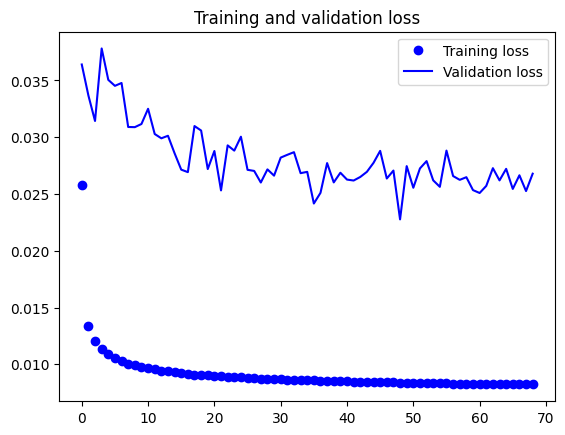

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Obtain the encoded training set and validation set.

In [48]:
x_train_encoded = encoder.predict(x_train)
x_valid_encoded = encoder.predict(x_valid)

print(x_train_encoded.shape, x_valid_encoded.shape)

157/157 [==============================] - 1s 3ms/step
(55000, 16) (5000, 16)


## Cluster encoded training data to select 50 images for labeling

First, we use k-means to find 50 centroids of the encoded training images and label these images.

In [49]:
from sklearn.cluster import KMeans
k=50
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_train_encoded)
cluster_labels = kmeans.predict(x_train_encoded)

representative_digit_idx = []
for cluster_idx in range(k):
    indices = np.where(cluster_labels == cluster_idx)[0]
    representative_digit_idx.append(indices[0])
x_representative_digits = x_train[representative_digit_idx]

C:\Users\varsh\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Display these 50 images.

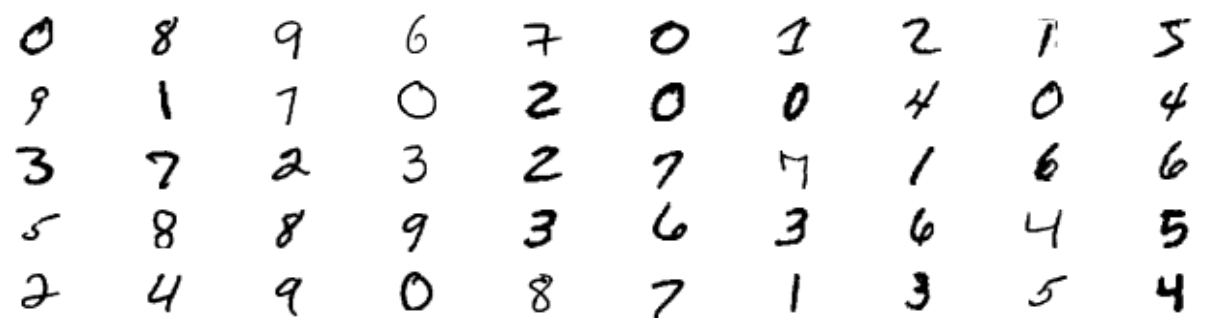

In [50]:
plt.figure(figsize=(16, 4))
for index, x_representative_digit in enumerate(x_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(x_representative_digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

Print the labels to confirm they are correct.

In [51]:
y_representative_digits = np.empty([k])
for i, idx in enumerate(representative_digit_idx):
  y_representative_digits[i] = y_train[idx]
print(y_representative_digits)

[0. 8. 9. 6. 7. 0. 1. 2. 1. 5. 9. 1. 7. 0. 2. 0. 0. 4. 0. 4. 3. 7. 2. 3.
 2. 7. 7. 1. 6. 6. 5. 8. 8. 9. 3. 6. 3. 6. 4. 5. 2. 4. 9. 0. 8. 7. 1. 3.
 5. 4.]


In [52]:
print(x_representative_digits.shape)
print(y_representative_digits.shape)

(50, 28, 28, 1)
(50,)


## Propagate labels and train model for classification

Propagate labels to images that are close to the 50 centroids in the latent space. Hint: study the code provied from the clustering module and try different percentile_closest values.

In [53]:
percentile_closest = 80

x_digits_dist = np.zeros((len(x_train), k))

x_cluster_dist = x_digits_dist[np.arange(len(x_train_encoded)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = x_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (x_cluster_dist > cutoff_distance)
    x_cluster_dist[in_cluster & above_cutoff] = -1

Prepare data for classification. Use images with propogated labels and save 5,000 images for validation.  

In [54]:
partially_propagated = (x_cluster_dist != -1)
x_train_partially_propagated = x_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

In [55]:
print(x_train_partially_propagated.shape)
print(y_train_partially_propagated.shape)

(55000, 28, 28, 1)
(55000,)


In [56]:
x_rep_train = x_train_partially_propagated[:-5000]
y_rep_train = y_train_partially_propagated[:-5000]
x_rep_valid = x_train_partially_propagated[-5000:]
y_rep_valid = y_train_partially_propagated[-5000:]

In [57]:
print(x_rep_train.shape, x_rep_valid.shape)

(50000, 28, 28, 1) (5000, 28, 28, 1)


In [58]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(y_rep_train)
valid_labels = to_categorical(y_rep_valid)
test_labels = to_categorical(y_test)

Define the image classification model.

In [59]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), strides=2, padding="same", activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 32)          0         
 D)                                                              
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                4

Complie the model and train the model. 

In [60]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train the model. Use callbacks to restore the best model for later use.

In [61]:
history = model.fit(x_rep_train, train_labels, validation_data=(x_rep_valid, valid_labels), epochs=100, batch_size=32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)])

Epoch 1/100
1563/1563 [==============================] - 19s 10ms/step - loss: 0.3439 - accuracy: 0.8933 - val_loss: 0.1315 - val_accuracy: 0.9590
Epoch 2/100
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1102 - accuracy: 0.9651 - val_loss: 0.0888 - val_accuracy: 0.9704
Epoch 3/100
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0788 - accuracy: 0.9759 - val_loss: 0.0805 - val_accuracy: 0.9744
Epoch 4/100
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0615 - accuracy: 0.9813 - val_loss: 0.0823 - val_accuracy: 0.9748
Epoch 5/100
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0524 - accuracy: 0.9835 - val_loss: 0.0809 - val_accuracy: 0.9750
Epoch 6/100
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0424 - accuracy: 0.9867 - val_loss: 0.0686 - val_accuracy: 0.9802
Epoch 7/100
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 0

Plot the training and validation accuracies and decide whehter we need to go back to change settings or we can proceed to the final step. Note we should only run the final step once.

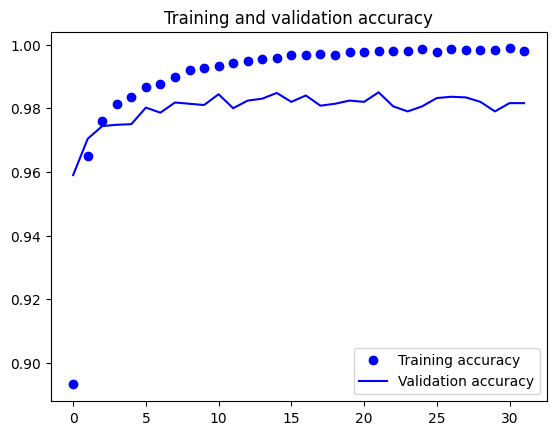

In [62]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

## Final step: test accuracy and grading

Note, we should only run this step once. We should look at the validation accuracy results before this step. If we are happy with the results, we run this step. Otherwise, we adjust settings in the previous steps until we get satisfying validation accuracy results.

In [63]:
test_loss, test_acc = model.evaluate(x_test, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.0591 - accuracy: 0.9866


In [64]:
grade = max(min((test_acc - 0.975)*10000,100), 0)
print('My grade: ', grade)

My grade:  100
